# Sensitivity Analysis

Performing H2S recovery sensitivity analysis...
Analyzing H2S recovery: 97.0%
Analyzing H2S recovery: 98.0%


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3414430.py:223: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  solution = fsolve(equations, guess, xtol=1e-12)


Analyzing H2S recovery: 99.0%
Analyzing H2S recovery: 99.9%
Analyzing H2S recovery: 99.99%
Analyzing H2S recovery: 99.999%


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3414430.py:223: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  solution = fsolve(equations, guess, xtol=1e-12)



Successfully analyzed 6 recovery targets
Failed recoveries: []


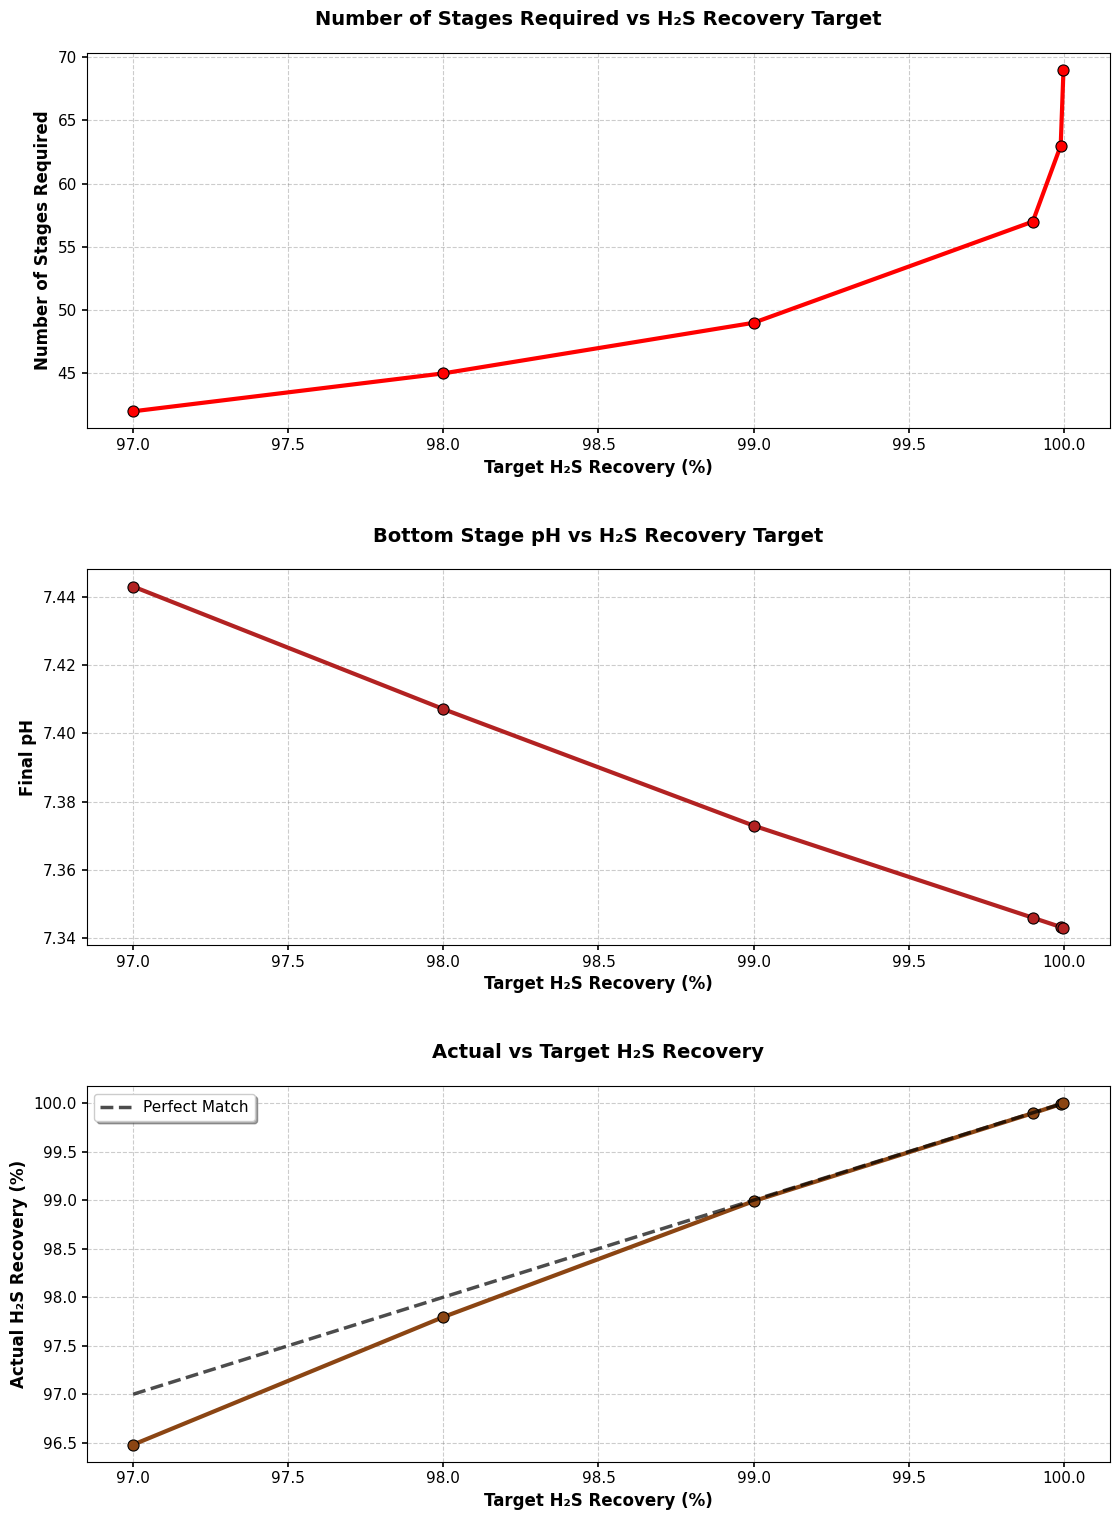

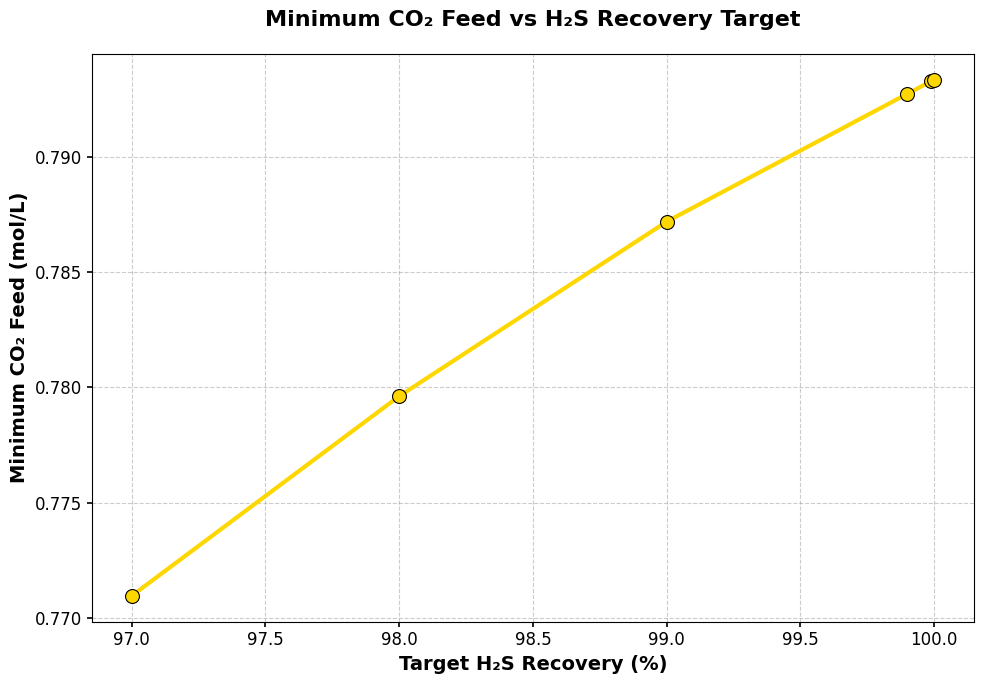

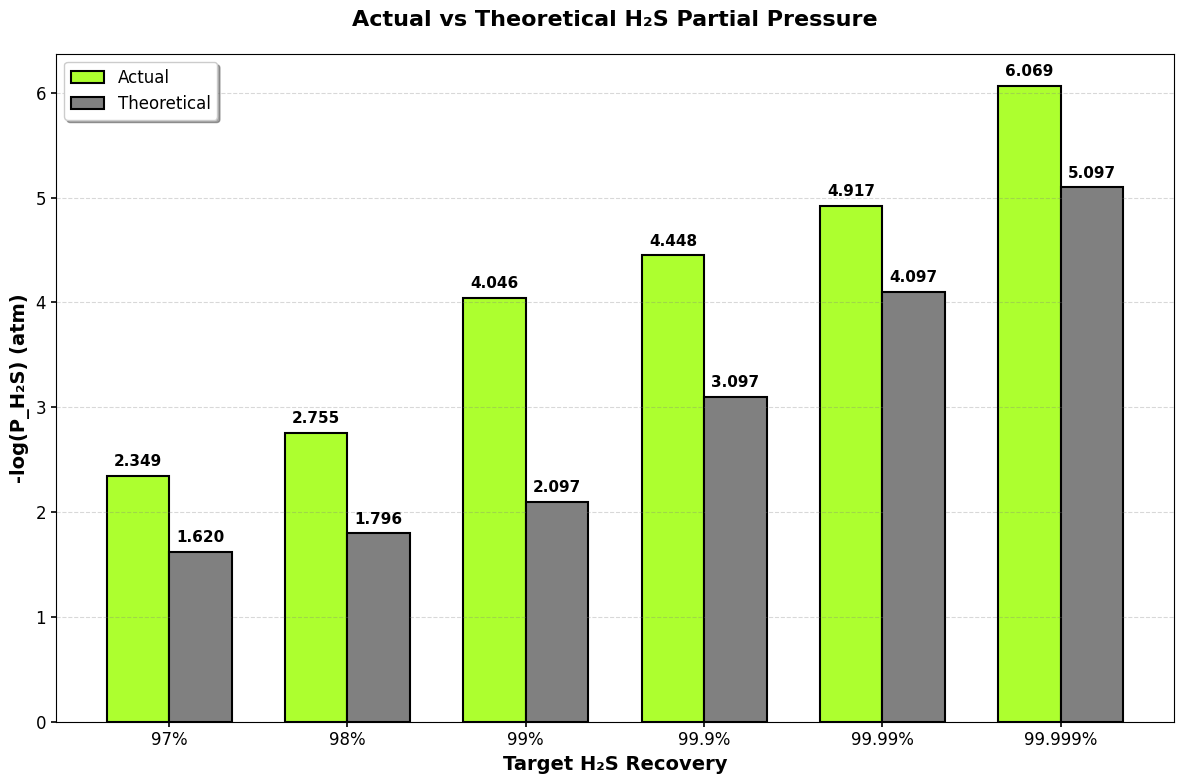

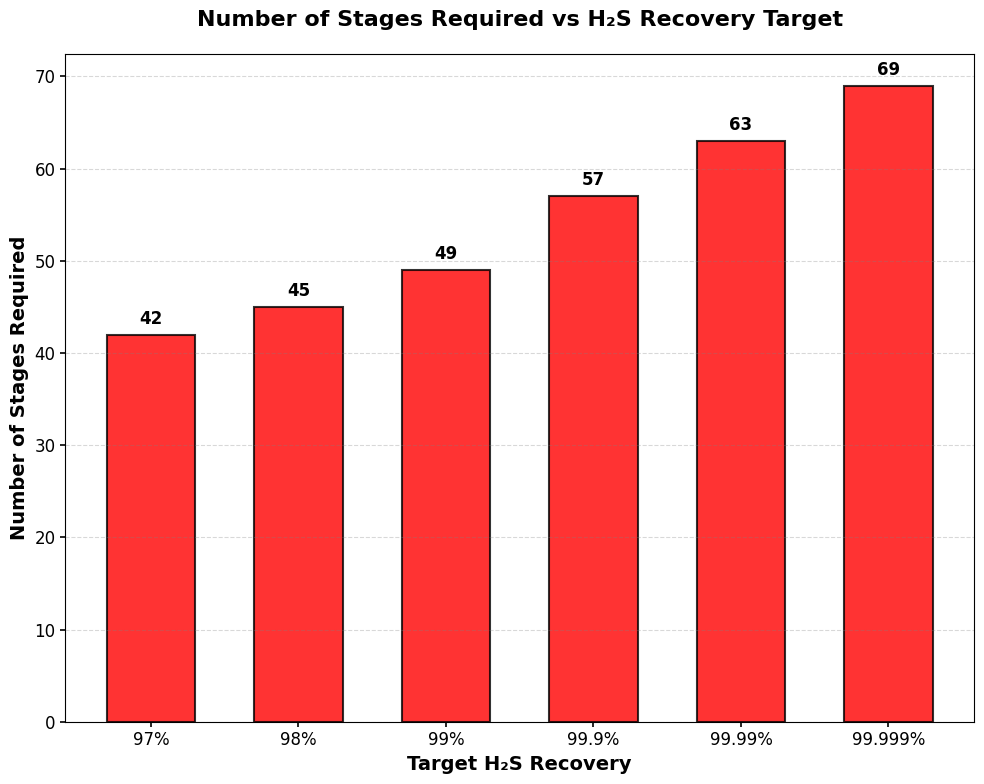

In [44]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =============================================================================================
# H2S RECOVERY SENSITIVITY ANALYSIS FOR STRIPPING COLUMN
# =============================================================================================
# H2S Recovery range for sensitivity analysis (90% to 99.999%)
recovery_range = np.arange(97, 100, 1)  # 97% to 99% in 1% increments
recovery_range = np.append(recovery_range, [99.9, 99.99, 99.999])  # Add high recovery points
recovery_range = np.sort(recovery_range)
# =============================================================================================

# Base operating conditions
T_operating = 25        # °C
P_operating = 1         # atm
V_stage = 180           # L
L_flow = 1              # L/s
G_flow_out_top = 0.9    # mol/s (from top of column)
ε_gas_fraction = 5      # %
d_bubble_mm = 5         # mm
max_stages = 1000       # Maximum number of stages

# Feed concentrations (at the top of column)
c_NaHS_feed = 0.8        # mol/L
c_CO2_feed = 0           # mol/L
c_H2CO3_feed = 0         # mol/L
c_HCO3_feed = 0          # mol/L
c_CO3_feed = 0           # mol/L
c_H2S_feed = 0           # mol/L
c_S_feed = 0             # mol/L

# Equilibrium constants and property functions
def K_eq(T):
    K_eq = 1/(0.04020944211255422*(np.e**(0.2130531302959603*T)) + 838.3007987989027)
    return K_eq

def K_1c(T):
    K_1c = 10**(-0.994 - (610.5/(T + 273.15)))
    return K_1c

def K_2c(T):
    K_2c = 10**(452.094 - (21263.61/(T + 273.15)) - (68.483143*np.log((T + 273.15))))
    return K_2c

def K_1s(T):
    K_1s = 10**(-32.55 - (1519.44/(T + 273.15)) + (15.672*np.log10((T + 273.15))) - (0.02722*(T + 273.15)))
    return K_1s

def K_2s(T):
    K_2s = 10**(-(4500/(T + 273.15)) - (12.6*np.log10((T + 273.15)/298.15)) + 1.29)
    return K_2s

def K_w(T):
    K_w = 10**(-(142613.6/(T + 273.15)) - (4229.195*np.log10((T + 273.15))) + (9.7384*(T + 273.15)) - (0.0129638*(T + 273.15)**2) + (1.15068e-5 *(T + 273.15)**3) - (4.602e-9 *(T + 273.15)**4) + 8909.483)
    return K_w

def k_f(T):
    k_f = np.e**(22.66 - (7799/(T + 273.15)))
    return k_f

# Physical property functions
d_bubble_m = d_bubble_mm/1000
a = (6*(ε_gas_fraction/100))/d_bubble_m
g = 9.182
MM_H2O = 18.01528

def liquid_surface_tension(T):
    factor = (647.15 - (T + 273.15))/647.15
    σ_L = (235.8e-3)*(1 - 0.625*factor)*(factor**1.256)
    return σ_L

def liquid_density(T):
    ρ_L = -13.851 + (0.64038*(T + 273.15)) - (0.0019124*((T + 273.15)**2)) + ((1.8211e-6)*((T + 273.15)**3))
    return ρ_L*(MM_H2O/1000)*(10**3)

def liquid_dynamic_viscosity(T):
    μ_L = np.e**(-52.843 + (3703.6/(T + 273.15)) + (5.866*np.log(T + 273.15)) - ((5.879e-29)*((T + 273.15)**10)))
    return μ_L

def bubble_rising_velocity(T):
    σ_L = liquid_surface_tension(T)
    ρ_L = liquid_density(T)
    u_b = (((2.14*σ_L)/(d_bubble_m*ρ_L)) + (0.505*g*d_bubble_m))**0.5
    return u_b

def liquid_diffusivity_CO2(T):
    D_L_25_CO2 = (1.96e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_CO2 = D_L_25_CO2*μ_L_25/(25 + 273.15)
    D_L_CO2 = constant_25_CO2*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_CO2

def liquid_side_mass_transfer_coefficient_CO2(T):
    k_L_CO2 = 2*((liquid_diffusivity_CO2(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_CO2

def k_La_CO2_func(T):
    k_La_CO2 = a*liquid_side_mass_transfer_coefficient_CO2(T)
    return k_La_CO2

def liquid_diffusivity_H2S(T):
    D_L_25_H2S = (1.61e-5)/(100**2)
    μ_L_25 = liquid_dynamic_viscosity(25)
    constant_25_H2S = D_L_25_H2S*μ_L_25/(25 + 273.15)
    D_L_H2S = constant_25_H2S*(T + 273.15)/liquid_dynamic_viscosity(T)
    return D_L_H2S

def liquid_side_mass_transfer_coefficient_H2S(T):
    k_L_H2S = 2*((liquid_diffusivity_H2S(T)*bubble_rising_velocity(T))/(np.pi*d_bubble_m))**0.5
    return k_L_H2S

def k_La_H2S_func(T):
    k_La_H2S = a*liquid_side_mass_transfer_coefficient_H2S(T)
    return k_La_H2S

def P_vap_H2O(T):
    A_H2O = 4.6543
    B_H2O = 1435.264
    C_H2O = -64.848
    P_vap_H2O = 10**(A_H2O - (B_H2O / ((T + 273.15) + C_H2O)))
    return P_vap_H2O * 0.986923

def k_H_CO2(T):
    k_H_CO2_start = 0.034*np.e**(2600*((1/(T + 273.15)) - (1/298.15)))
    k_H_CO2 = k_H_CO2_start*liquid_density(T)*(1.01325/1000)
    return k_H_CO2

def k_H_H2S(T):
    k_H_H2S_start = 0.1*np.e**(2300*((1/(T + 273.15)) - (1/298.15)))
    k_H_H2S = k_H_H2S_start*liquid_density(T)*(1.01325/1000)
    return k_H_H2S

def solve_stage(liquid_in, gas_out, stage_num, T_op):
    """
    Solve a single stage given liquid inlet and gas outlet conditions
    """
    # Calculate temperature-dependent constants
    K_eq_val = K_eq(T_op)
    K_1c_val = K_1c(T_op)
    K_2c_val = K_2c(T_op)
    K_1s_val = K_1s(T_op)
    K_2s_val = K_2s(T_op)
    K_w_val = K_w(T_op)
    k_f_val = k_f(T_op)
    k_La_CO2 = k_La_CO2_func(T_op)
    k_La_H2S = k_La_H2S_func(T_op)
    k_H_CO2_val = k_H_CO2(T_op)
    k_H_H2S_val = k_H_H2S(T_op)
    
    # Extract input conditions
    c_Na_in = liquid_in['Na']
    c_H2S_in = liquid_in['H2S']
    c_HS_in = liquid_in['HS']
    c_S_in = liquid_in['S']
    c_CO2_in = liquid_in['CO2']
    c_H2CO3_in = liquid_in['H2CO3']
    c_HCO3_in = liquid_in['HCO3']
    c_CO3_in = liquid_in['CO3']
    
    G_flow_out = gas_out['flow']
    y_H2O_out = gas_out['H2O']
    y_H2S_out = gas_out['H2S']
    y_CO2_out = gas_out['CO2']
    
    # Calculate interfacial concentrations
    c_H2S_i_stage = k_H_H2S_val * y_H2S_out * P_operating
    c_CO2_i_stage = k_H_CO2_val * y_CO2_out * P_operating
    
    # Sodium is conserved
    c_Na_out = c_Na_in
    
    # Define equations for this stage with transformed variables
    def equations(vars):
        pH, y_scaled, z_scaled = vars  # pH, 1000*c_H2CO3_out, 1000*c_H2S_out
        
        # Convert back to actual concentrations
        c_H_out = 10**(-pH)
        c_H2CO3_out = y_scaled / 1000.0
        c_H2S_out = z_scaled / 1000.0
        
        # Calculate other concentrations
        c_OH_out = K_w_val / c_H_out
        c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
        c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
        c_HS_out = c_H2S_out * K_1s_val / c_H_out
        c_S_out = c_HS_out * K_2s_val / c_H_out

        c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                     (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)

        term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
        G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))

        y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
        y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in

        eq1 = c_Na_out + c_H_out - c_HCO3_out - 2*c_CO3_out - c_OH_out - c_HS_out - 2*c_S_out
        eq2 = (G_flow_out*y_CO2_out + L_flow*(c_CO2_out + c_H2CO3_out + c_HCO3_out + c_CO3_out) -
               G_flow_in*y_CO2_in - L_flow*(c_CO2_in + c_H2CO3_in + c_HCO3_in + c_CO3_in))
        eq3 = (G_flow_out*y_H2S_out + L_flow*(c_H2S_out + c_HS_out + c_S_out) -
               G_flow_in*y_H2S_in - L_flow*(c_H2S_in + c_HS_in + c_S_in))

        return [eq1, eq2, eq3]

    # Try multiple initial guesses with transformed variables
    initial_guesses = [
        [7.0, 1.0, 1.0],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1
        [6.8, 1.2, 1.0],      # pH=6.8, 1000*[H2CO3]=1.2, 1000*[H2S]=1
        [7.2, 0.8, 1.0],      # pH=7.2, 1000*[H2CO3]=0.8, 1000*[H2S]=1
        [7.0, 1.0, 1.2],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=1.2
        [7.0, 1.0, 0.8],      # pH=7, 1000*[H2CO3]=1, 1000*[H2S]=0.8
        [6.5, 1.5, 1.5],      # pH=6.5, 1000*[H2CO3]=1.5, 1000*[H2S]=1.5
        [7.5, 0.5, 0.5],      # pH=7.5, 1000*[H2CO3]=0.5, 1000*[H2S]=0.5
    ]
    
    best_solution = None
    best_residual = 1e10

    for guess in initial_guesses:
        try:
            solution = fsolve(equations, guess, xtol=1e-12)
            residual_vals = equations(solution)
            residual = sum([r**2 for r in residual_vals])
            
            # Check if solution is physically reasonable
            pH_val, y_scaled_val, z_scaled_val = solution
            c_H_val = 10**(-pH_val)
            c_H2CO3_val = y_scaled_val / 1000.0
            c_H2S_val = z_scaled_val / 1000.0
            
            # Physical constraints
            if (4 <= pH_val <= 14 and c_H2CO3_val > 0 and c_H2S_val > 0 and 
                y_scaled_val > 0 and z_scaled_val > 0 and residual < best_residual):
                best_residual = residual
                best_solution = solution
        except:
            continue

    if best_solution is None:
        raise ValueError(f"Could not converge stage {stage_num} at recovery target")

    # Extract solution and convert back to actual concentrations
    pH_out, y_scaled_out, z_scaled_out = best_solution
    c_H_out = 10**(-pH_out)
    c_H2CO3_out = y_scaled_out / 1000.0
    c_H2S_out = z_scaled_out / 1000.0
    
    # Calculate derived concentrations
    c_OH_out = K_w_val / c_H_out
    c_HCO3_out = c_H2CO3_out * K_1c_val / c_H_out
    c_CO3_out = c_HCO3_out * K_2c_val / c_H_out
    c_HS_out = c_H2S_out * K_1s_val / c_H_out
    c_S_out = c_HS_out * K_2s_val / c_H_out
    
    c_CO2_out = ((L_flow*(c_H2CO3_out + c_HCO3_out + c_CO3_out) - L_flow*(c_H2CO3_in + c_HCO3_in + c_CO3_in)) /
                 (k_f_val*(1 - ε_gas_fraction/100)*V_stage)) + (c_H2CO3_out/K_eq_val)
    
    term2 = k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out) + k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out)
    G_flow_in = G_flow_out + (term2/(1 - y_H2O_out))
    
    y_H2S_in = ((G_flow_out*y_H2S_out) + (k_La_H2S*V_stage*(c_H2S_i_stage - c_H2S_out))) / G_flow_in
    y_CO2_in = ((G_flow_out*y_CO2_out) + (k_La_CO2*V_stage*(c_CO2_i_stage - c_CO2_out))) / G_flow_in
    y_H2O_in = y_H2O_out
    
    # Package outputs
    liquid_out = {
        'Na': c_Na_out,
        'H': c_H_out,
        'OH': c_OH_out,
        'CO2': c_CO2_out,
        'H2CO3': c_H2CO3_out,
        'HCO3': c_HCO3_out,
        'CO3': c_CO3_out,
        'H2S': c_H2S_out,
        'HS': c_HS_out,
        'S': c_S_out,
        'pH': pH_out
    }
    
    gas_in = {
        'flow': G_flow_in,
        'H2O': y_H2O_in,
        'CO2': y_CO2_in,
        'H2S': y_H2S_in
    }
    
    return liquid_out, gas_in, best_residual

def simulate_column_at_recovery(x_H2S_recovery_target):
    """
    Simulate the stripping column at a given H2S recovery target
    Returns: number of stages, final pH, bottom gas properties, actual recovery achieved, target_sulphur_remaining
    """
    
    # Initialize liquid feed at top (stage 1)
    liquid_feed = {
        'Na': c_NaHS_feed,
        'H2S': c_H2S_feed,
        'HS': c_NaHS_feed,  # Initial HS- from NaHS feed
        'S': c_S_feed,
        'CO2': c_CO2_feed,
        'H2CO3': c_H2CO3_feed,
        'HCO3': c_HCO3_feed,
        'CO3': c_CO3_feed
    }

    # Initialize gas outlet from top (stage 1)
    P_vap_H2O_val = P_vap_H2O(T_operating)
    y_H2O_top = P_vap_H2O_val/P_operating
    y_H2S_top = ((x_H2S_recovery_target/100)*c_NaHS_feed*L_flow)/G_flow_out_top
    y_CO2_top = 1 - y_H2O_top - y_H2S_top

    gas_top = {
        'flow': G_flow_out_top,
        'H2O': y_H2O_top,
        'CO2': y_CO2_top,
        'H2S': y_H2S_top
    }

    # Calculate target sulphur remaining in liquid
    total_sulphur_feed = c_NaHS_feed
    target_sulphur_remaining = total_sulphur_feed * (1 - x_H2S_recovery_target/100)

    # Solve column from top to bottom
    current_liquid = liquid_feed.copy()
    current_gas = gas_top.copy()

    converged = False
    final_stage = 0
    previous_total_sulphur = None
    final_liquid_out = None
    final_gas_in = None

    for stage in range(1, max_stages + 1):
        try:
            liquid_out, gas_in, residual = solve_stage(current_liquid, current_gas, stage, T_operating)
            
            # Calculate sulphur mass balance for this stage
            total_sulphur_out = liquid_out['H2S'] + liquid_out['HS'] + liquid_out['S']
            
            # Check if we should stop BEFORE reaching the target
            if previous_total_sulphur is not None:
                # If current stage would go below target, stop at previous stage
                if total_sulphur_out <= target_sulphur_remaining:
                    converged = True
                    final_stage = stage - 1
                    break
            
            # Store current results
            final_liquid_out = liquid_out.copy()
            final_gas_in = gas_in.copy()
            
            # Store current sulphur content for next iteration
            previous_total_sulphur = total_sulphur_out
            
            # Update for next stage
            current_liquid = liquid_out.copy()
            current_gas = gas_in.copy()
            
        except Exception as e:
            print(f"Error at recovery {x_H2S_recovery_target}%, stage {stage}: {e}")
            break

    if not converged and final_stage == 0:
        final_stage = len(range(1, stage))
    
    # Calculate actual recovery achieved
    if final_liquid_out is not None:
        final_total_sulphur = final_liquid_out['H2S'] + final_liquid_out['HS'] + final_liquid_out['S']
        actual_recovery = (1 - final_total_sulphur/total_sulphur_feed) * 100
    else:
        actual_recovery = 0
        
    return final_stage, final_liquid_out, final_gas_in, actual_recovery, target_sulphur_remaining

# Perform H2S recovery sensitivity analysis
print("Performing H2S recovery sensitivity analysis...")
print("="*80)

results = []
failed_recoveries = []
target_sulphur_remaining_list = []  # Store target values for plotting

for recovery in recovery_range:
    print(f"Analyzing H2S recovery: {recovery}%")
    try:
        n_stages, final_liquid, final_gas, actual_recovery, target_sulphur = simulate_column_at_recovery(recovery)
        
        if final_liquid is not None and final_gas is not None:
            # Calculate additional performance metrics
            total_sulphur_remaining = final_liquid['H2S'] + final_liquid['HS'] + final_liquid['S']
            H2S_stripped = (c_NaHS_feed - total_sulphur_remaining) * L_flow  # mol/s
            
            results.append({
                'Target_Recovery': recovery,
                'Actual_Recovery': actual_recovery,
                'Stages': n_stages,
                'Final_pH': final_liquid['pH'],
                'Total_Sulphur_Remaining': total_sulphur_remaining,
                'H2S_Stripped_Rate': H2S_stripped,
                'Bottom_Gas_Flow': final_gas['flow'],
                'Bottom_CO2_Fraction': final_gas['CO2'],
                'Bottom_H2S_Fraction': final_gas['H2S'],
                'Bottom_H2O_Fraction': final_gas['H2O'],
                'Bottom_H2S_Conc': final_liquid['H2S'],
                'Bottom_HS_Conc': final_liquid['HS'],
                'Bottom_S_Conc': final_liquid['S'],
                'Bottom_H2CO3_Conc': final_liquid['H2CO3'],
                'Bottom_HCO3_Conc': final_liquid['HCO3'],
                'Bottom_CO3_Conc': final_liquid['CO3']
            })
            
            target_sulphur_remaining_list.append(target_sulphur)
        else:
            failed_recoveries.append(recovery)
            print(f"  Failed to converge at {recovery:.1f}% recovery")
    except Exception as e:
        failed_recoveries.append(recovery)
        print(f"  Failed at {recovery:.1f}% recovery: {e}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

if len(df_results) == 0:
    print("No successful simulations!")
else:
    print(f"\nSuccessfully analyzed {len(df_results)} recovery targets")
    print(f"Failed recoveries: {[f'{r:.1f}%' for r in failed_recoveries]}")
    
    # Create sensitivity analysis plots
    plt.style.use('default')
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11
    plt.rcParams['legend.fontsize'] = 11

    # Three-panel plot
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16))

    # Plot 1: Number of stages vs H2S recovery
    ax1.plot(df_results['Target_Recovery'][-6:], df_results['Stages'][-6:], 'o-', 
             linewidth=3, markersize=8, color='red', markerfacecolor='red', 
             markeredgecolor='black', markeredgewidth=0.8)
    ax1.set_xlabel('Target H₂S Recovery (%)', fontweight='bold')
    ax1.set_ylabel('Number of Stages Required', fontweight='bold')
    ax1.set_title('Number of Stages Required vs H₂S Recovery Target', fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax1.tick_params(axis='both', which='major', labelsize=11, width=1.2)

    # Plot 2: Final pH vs H2S recovery
    ax2.plot(df_results['Target_Recovery'][-6:], df_results['Final_pH'][-6:], 'o-', 
             linewidth=3, markersize=8, color='firebrick', markerfacecolor='firebrick',
             markeredgecolor='black', markeredgewidth=0.8)
    ax2.set_xlabel('Target H₂S Recovery (%)', fontweight='bold')
    ax2.set_ylabel('Final pH', fontweight='bold')
    ax2.set_title('Bottom Stage pH vs H₂S Recovery Target', fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax2.tick_params(axis='both', which='major', labelsize=11, width=1.2)

    # Plot 3: Actual vs Target Recovery
    ax3.plot(df_results['Target_Recovery'][-6:], df_results['Actual_Recovery'][-6:], 'o-', 
             linewidth=3, markersize=8, color='saddlebrown', markerfacecolor='saddlebrown',
             markeredgecolor='black', markeredgewidth=0.8)
    ax3.plot(df_results['Target_Recovery'][-6:], df_results['Target_Recovery'][-6:], 
             '--', alpha=0.7, linewidth=2.5, label='Perfect Match', color='black')
    ax3.set_xlabel('Target H₂S Recovery (%)', fontweight='bold')
    ax3.set_ylabel('Actual H₂S Recovery (%)', fontweight='bold')
    ax3.set_title('Actual vs Target H₂S Recovery', fontweight='bold', pad=20)
    ax3.legend(loc='best', frameon=True, fancybox=True, shadow=True)
    ax3.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    ax3.tick_params(axis='both', which='major', labelsize=11, width=1.2)

    plt.tight_layout(pad=3.0)
    plt.show()

    # minimum CO2 concentration plot
    minCO2 = df_results['Bottom_H2CO3_Conc'] + df_results['Bottom_HCO3_Conc'] + df_results['Bottom_CO3_Conc']
    plt.figure(figsize=(10, 7))
    plt.plot(df_results['Target_Recovery'][-6:], minCO2[-6:], 'o-', 
             linewidth=3, markersize=10, color='gold', markerfacecolor='gold', 
             markeredgecolor='black', markeredgewidth=0.8)
    plt.xlabel('Target H₂S Recovery (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Minimum CO₂ Feed (mol/L)', fontsize=14, fontweight='bold')
    plt.title('Minimum CO₂ Feed vs H₂S Recovery Target', fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8, color='grey')
    plt.tick_params(axis='both', which='major', labelsize=12, width=1.2)
    plt.tight_layout()
    plt.show()

    # Actual vs Theoretical -log(P_H2S) comparison
    labels = ['97%', '98%', '99%', '99.9%', '99.99%', '99.999%']
    data1 = -np.log10(df_results['Bottom_H2S_Fraction'][-6:]*P_operating)  # actual
    # Convert target_sulphur_remaining_list to numpy array and get last 6 values
    target_sulphur_remaining_array = np.array(target_sulphur_remaining_list)
    data2 = -np.log10(target_sulphur_remaining_array[-6:])  # theoretical

    x = np.arange(len(labels))  # Label locations
    width = 0.35  # Width of the bars

    # Bar plot
    fig, ax = plt.subplots(figsize=(12, 8))
    bars1 = ax.bar(x - width/2, np.round(data1, 3), width, label='Actual', 
                   color='greenyellow', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, np.round(data2, 3), width, label='Theoretical', 
                   color='grey', edgecolor='black', linewidth=1.5)

    # Labels and titles
    ax.set_xlabel('Target H₂S Recovery', fontsize=14, fontweight='bold')
    ax.set_ylabel('-log(P_H₂S) (atm)', fontsize=14, fontweight='bold')
    ax.set_title('Actual vs Theoretical H₂S Partial Pressure', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.legend(loc='best', fontsize=12, frameon=True, fancybox=True, shadow=True)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', linewidth=0.8, color='grey')

    # Bar value annotations
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Number of stages vs recovery bar chart
    labels = ['97%', '98%', '99%', '99.9%', '99.99%', '99.999%']
    data1 = df_results['Stages'][-6:]

    x = np.arange(len(labels))  # Label locations
    width = 0.6  # Width of the bars

    # Bar plot
    fig, ax = plt.subplots(figsize=(10, 8))
    bars1 = ax.bar(x, np.round(data1, 0), width, color='red', 
                   edgecolor='black', linewidth=1.5, alpha=0.8)

    # Labels and titles
    ax.set_xlabel('Target H₂S Recovery', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Stages Required', fontsize=14, fontweight='bold')
    ax.set_title('Number of Stages Required vs H₂S Recovery Target', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
    ax.grid(True, alpha=0.3, linestyle='--', axis='y', linewidth=0.8, color='grey')

    # Bar value annotations
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Empirical Plot for Number of Stages Required vs H₂S Recovery Target

1st Degree Polynomial: R² = 0.808075
2nd Degree Polynomial: R² = 0.895062
3rd Degree Polynomial: R² = 0.918647
4th Degree Polynomial: R² = 0.919160
Failed to fit Exponential Function: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Failed to fit Exponential Decay With Offset: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Exponential With Power: R² = -0.000000
Simple Logarithmic: R² = 0.805991
Complex Logarithmic: R² = 0.894672
Power Law With Offset: R² = 0.000000
Failed to fit Power Law With Exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Rational Function: R² = 0.808075
Complex Rational Function: R² = 0.993317


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\1872694306.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, target_data, stages_data, p0=initial_guess, maxfev=10000)


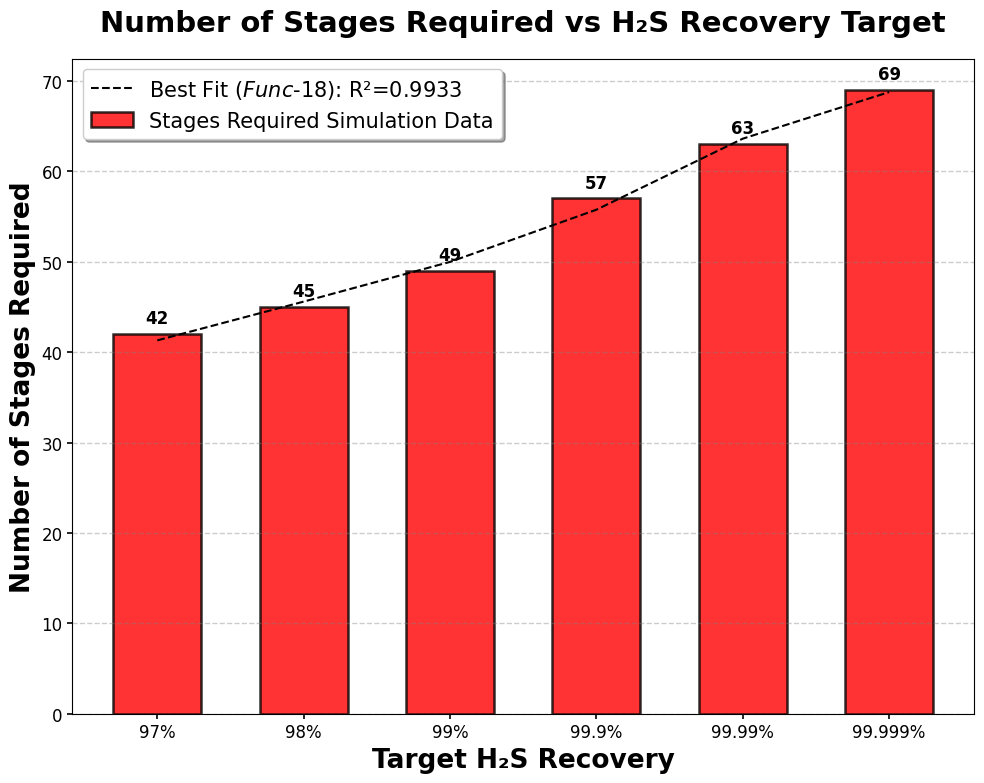


Best Parametric Fit: Complex Rational Function
R² = 0.993317
Best Parametric Form: Stages = (a*Tar² + b*Tar + c) / (Tar² + d*Tar + e)
Parameters:
   a = -1.303584e+03
   b = 2.437261e+05
   c = -1.133642e+07
   d = -5.148425e+02
   e = 4.148927e+04


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
target_data = df_results['Target_Recovery'].values
stages_data = df_results['Stages'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, target_data, stages_data, p0=initial_guess, maxfev=10000)
        y_pred = func(target_data, *popt)

        # R² calculation
        ss_res = np.sum((stages_data - y_pred) ** 2)
        ss_tot = np.sum((stages_data - np.mean(stages_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

labels = ['97%', '98%', '99%', '99.9%', '99.99%', '99.999%']
data1 = df_results['Stages'][-6:]
target_values = df_results['Target_Recovery'][-6:].values

x = np.arange(len(labels))  # Label locations
width = 0.6  # Width of the bars

# Bar plot
fig, ax = plt.subplots(figsize=(10, 8))
bars1 = ax.bar(x, np.round(data1, 0), width, color='red', 
               edgecolor='black', linewidth=1.8, alpha=0.8, label='Stages Required Simulation Data')

# Add fitted line to the bar plot
if best_fit is not None:
    y_fit = best_fit(target_values, *best_params)
    ax.plot(x, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}18}}$): R²={best_r2:.4f}")
    ax.legend(loc='best', fontsize=15, frameon=True, fancybox=True, shadow=True)

# Labels and titles
ax.set_xlabel('Target H₂S Recovery', fontsize=19, fontweight='bold')
ax.set_ylabel('Number of Stages Required', fontsize=19, fontweight='bold')
ax.set_title('Number of Stages Required vs H₂S Recovery Target', fontsize=21, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
ax.grid(True, alpha=0.4, linestyle='--', axis='y', linewidth=1, color='grey')

# Bar value annotations
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "Stages = a*Tar + b",
        "2nd Degree Polynomial": "Stages = a*Tar² + b*Tar + c",
        "3rd Degree Polynomial": "Stages = a*Tar³ + b*Tar² + c*Tar + d",
        "4th Degree Polynomial": "Stages = a*Tar⁴ + b*Tar³ + c*Tar² + d*Tar + e",
        "Exponential Function": "Stages = a*exp(b*Tar) + c",
        "Exponential Decay With Offset": "Stages = a*exp(-b*Tar) + c*Tar + d",
        "Exponential With Power": "Stages = a*exp(b*Tar^c) + d",
        "Simple Logarithmic": "Stages = a*ln(Tar) + b",
        "Complex Logarithmic": "Stages = a*ln(Tar) + b*Tar + c",
        "Power Law With Offset": "Stages = a*Tar^b + c",
        "Power Law With Exponential": "Stages = a*Tar^b * exp(c*Tar) + d",
        "Simple Rational Function": "Stages = (a*Tar + b) / (Tar + c)",
        "Complex Rational Function": "Stages = (a*Tar² + b*Tar + c) / (Tar² + d*Tar + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Empirical Plot for Bottom Stage pH vs H₂S Recovery Target

1st Degree Polynomial: R² = 0.998741
2nd Degree Polynomial: R² = 0.999963
3rd Degree Polynomial: R² = 0.999994
4th Degree Polynomial: R² = 0.999994
Exponential Function: R² = 0.999956
Failed to fit Exponential Decay With Offset: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3827410199.py:15: RuntimeWarning: overflow encountered in exp
  def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3827410199.py:15: RuntimeWarning: overflow encountered in multiply
  def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3827410199.py:16: RuntimeWarning: overflow encountered in exp
  def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d


Failed to fit Exponential With Power: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Logarithmic: R² = 0.998999
Complex Logarithmic: R² = 0.999962
Power Law With Offset: R² = 0.000000
Failed to fit Power Law With Exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Rational Function: R² = 0.999951
Complex Rational Function: R² = 0.999992


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3827410199.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, target_data, pH_data, p0=initial_guess, maxfev=10000)


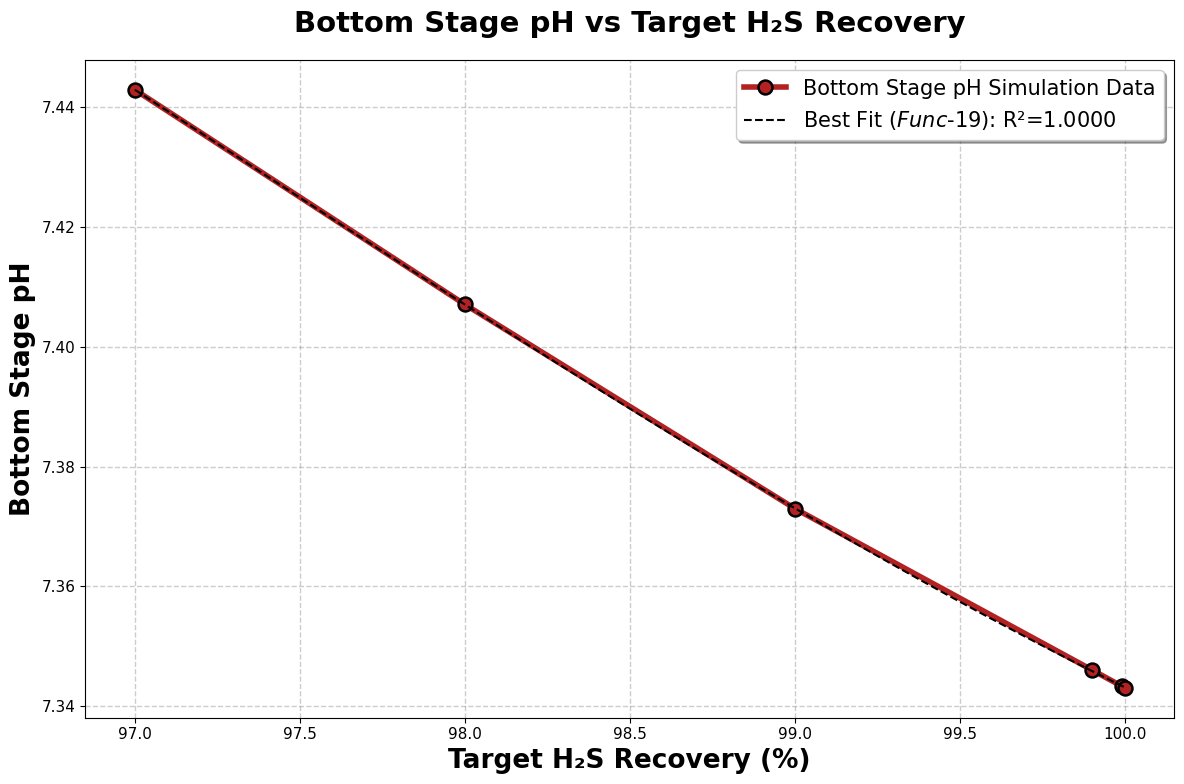


Best Parametric Fit: 3rd Degree Polynomial
R² = 0.999994
Best Parametric Form: pH = a*Tar³ + b*Tar² + c*Tar + d
Parameters:
   a = 3.750124e-04
   b = -1.093240e-01
   c = 1.058729e+01
   d = -3.331591e+02


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
target_data = df_results['Target_Recovery'].values
pH_data = df_results['Final_pH'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, target_data, pH_data, p0=initial_guess, maxfev=10000)
        y_pred = func(target_data, *popt)

        # R² calculation
        ss_res = np.sum((pH_data - y_pred) ** 2)
        ss_tot = np.sum((pH_data - np.mean(pH_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

# Plot results
target_fine = np.linspace(target_data.min(), target_data.max(), 1000)

plt.figure(figsize=(12, 8))
plt.plot(target_data, pH_data, 'o-', linewidth=4, markersize=10,
         color='firebrick', markerfacecolor='firebrick', markeredgecolor='black',
         markeredgewidth=1.8, label='Bottom Stage pH Simulation Data')

if best_fit is not None:
    y_fit = best_fit(target_fine, *best_params)
    plt.plot(target_fine, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}19}}$): R²={best_r2:.4f}")

plt.xlabel('Target H₂S Recovery (%)', fontsize=19, fontweight='bold')
plt.ylabel('Bottom Stage pH', fontsize=19, fontweight='bold')
plt.title('Bottom Stage pH vs Target H₂S Recovery', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "pH = a*Tar + b",
        "2nd Degree Polynomial": "pH = a*Tar² + b*Tar + c",
        "3rd Degree Polynomial": "pH = a*Tar³ + b*Tar² + c*Tar + d",
        "4th Degree Polynomial": "pH = a*Tar⁴ + b*Tar³ + c*Tar² + d*Tar + e",
        "Exponential Function": "pH = a*exp(b*Tar) + c",
        "Exponential Decay With Offset": "pH = a*exp(-b*Tar) + c*Tar + d",
        "Exponential With Power": "pH = a*exp(b*Tar^c) + d",
        "Simple Logarithmic": "pH = a*ln(Tar) + b",
        "Complex Logarithmic": "pH = a*ln(Tar) + b*Tar + c",
        "Power Law With Offset": "pH = a*Tar^b + c",
        "Power Law With Exponential": "pH = a*Tar^b * exp(c*Tar) + d",
        "Simple Rational Function": "pH = (a*Tar + b) / (Tar + c)",
        "Complex Rational Function": "pH = (a*Tar² + b*Tar + c) / (Tar² + d*Tar + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Empirical Plot for Actual vs Target H₂S Recovery

1st Degree Polynomial: R² = 0.997324
2nd Degree Polynomial: R² = 0.999974
3rd Degree Polynomial: R² = 0.999990
4th Degree Polynomial: R² = 0.999991
Failed to fit Exponential Function: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Exponential Decay With Offset: R² = 0.997324
Exponential With Power: R² = 0.000000
Simple Logarithmic: R² = 0.997712
Complex Logarithmic: R² = 0.999973
Failed to fit Power Law With Offset: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3766049969.py:15: RuntimeWarning: overflow encountered in exp
  def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3766049969.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, target_data, actual_data, p0=initial_guess, maxfev=10000)
C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3766049969.py:19: RuntimeWarning: overflow encountered in power
  def power_law(x, a, b, c): return a * x**b + c


Failed to fit Power Law With Exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Rational Function: R² = 0.999953
Failed to fit Complex Rational Function: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


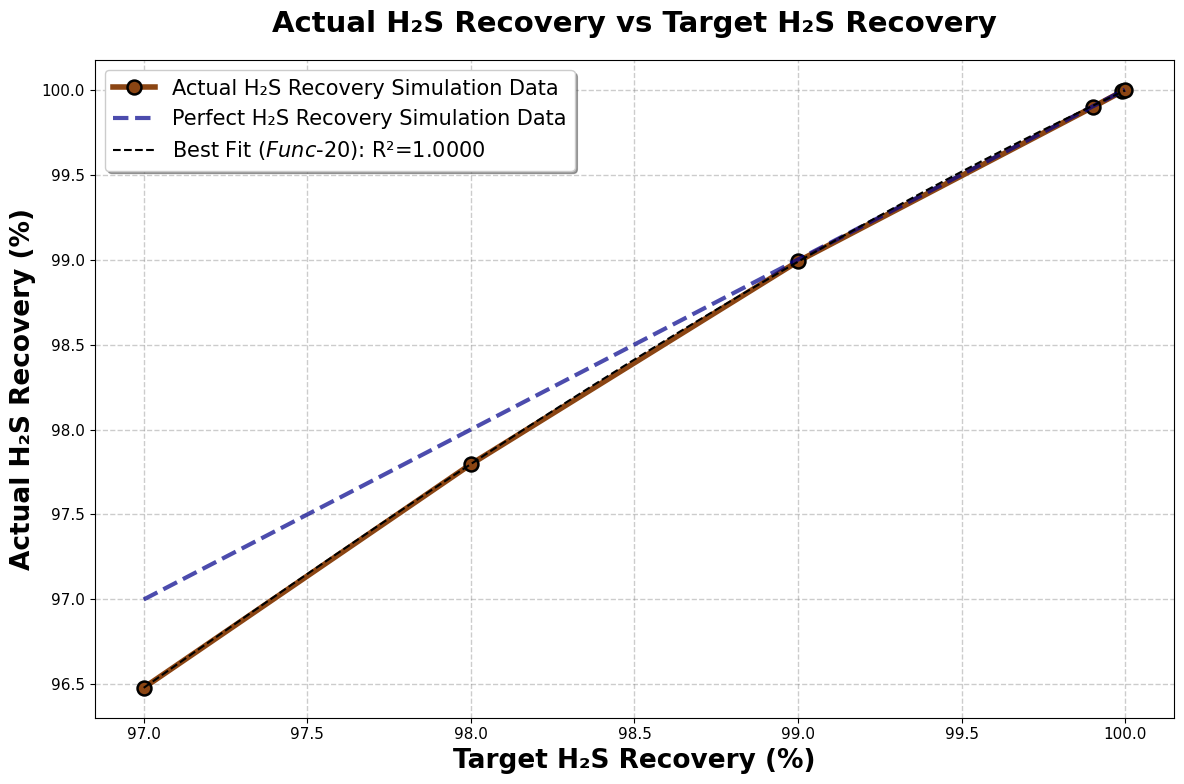


Best Parametric Fit: 4th Degree Polynomial
R² = 0.999991
Best Parametric Form: Actual Recovery = a*Tar⁴ + b*Tar³ + c*Tar² + d*Tar + e
Parameters:
   a = 8.340098e-04
   b = -3.380002e-01
   c = 5.124921e+01
   d = -3.444971e+03
   e = 8.670428e+04


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
target_data = df_results['Target_Recovery'].values
actual_data = df_results['Actual_Recovery'].values

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, target_data, actual_data, p0=initial_guess, maxfev=10000)
        y_pred = func(target_data, *popt)

        # R² calculation
        ss_res = np.sum((actual_data - y_pred) ** 2)
        ss_tot = np.sum((actual_data - np.mean(actual_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

# Plot results
target_fine = np.linspace(target_data.min(), target_data.max(), 1000)

plt.figure(figsize=(12, 8))
plt.plot(target_data, actual_data, 'o-', linewidth=4, markersize=10,
         color='saddlebrown', markerfacecolor='saddlebrown', markeredgecolor='black',
         markeredgewidth=1.8, label='Actual H₂S Recovery Simulation Data')

plt.plot(target_data, target_data, 
             '--', alpha=0.7, linewidth=3, label='Perfect H₂S Recovery Simulation Data', color='darkblue')

if best_fit is not None:
    y_fit = best_fit(target_fine, *best_params)
    plt.plot(target_fine, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}20}}$): R²={best_r2:.4f}")

plt.xlabel('Target H₂S Recovery (%)', fontsize=19, fontweight='bold')
plt.ylabel('Actual H₂S Recovery (%)', fontsize=19, fontweight='bold')
plt.title('Actual H₂S Recovery vs Target H₂S Recovery', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "Actual Recovery = a*Tar + b",
        "2nd Degree Polynomial": "Actual Recovery = a*Tar² + b*Tar + c",
        "3rd Degree Polynomial": "Actual Recovery = a*Tar³ + b*Tar² + c*Tar + d",
        "4th Degree Polynomial": "Actual Recovery = a*Tar⁴ + b*Tar³ + c*Tar² + d*Tar + e",
        "Exponential Function": "Actual Recovery = a*exp(b*Tar) + c",
        "Exponential Decay With Offset": "Actual Recovery = a*exp(-b*Tar) + c*Tar + d",
        "Exponential With Power": "Actual Recovery = a*exp(b*Tar^c) + d",
        "Simple Logarithmic": "Actual Recovery = a*ln(Tar) + b",
        "Complex Logarithmic": "Actual Recovery = a*ln(Tar) + b*Tar + c",
        "Power Law With Offset": "Actual Recovery = a*Tar^b + c",
        "Power Law With Exponential": "Actual Recovery = a*Tar^b * exp(c*Tar) + d",
        "Simple Rational Function": "Actual Recovery = (a*Tar + b) / (Tar + c)",
        "Complex Rational Function": "Actual Recovery = (a*Tar² + b*Tar + c) / (Tar² + d*Tar + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Empirical Plot for Minimum CO₂ Feed vs H₂S Recovery Target

1st Degree Polynomial: R² = 0.995616
2nd Degree Polynomial: R² = 0.999981
3rd Degree Polynomial: R² = 0.999991
4th Degree Polynomial: R² = 0.999991
Exponential Function: R² = 0.999960
Exponential Decay With Offset: R² = 0.995616
Failed to fit Exponential With Power: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Simple Logarithmic: R² = 0.996117
Complex Logarithmic: R² = 0.999979
Failed to fit Power Law With Offset: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3819026341.py:49: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, target_data, min_co2_data, p0=initial_guess, maxfev=10000)
C:\Users\Damia\AppData\Local\Temp\ipykernel_22816\3819026341.py:19: RuntimeWarning: overflow encountered in power
  def power_law(x, a, b, c): return a * x**b + c


Power Law With Exponential: R² = 0.999979
Simple Rational Function: R² = 0.999946
Complex Rational Function: R² = 0.999991


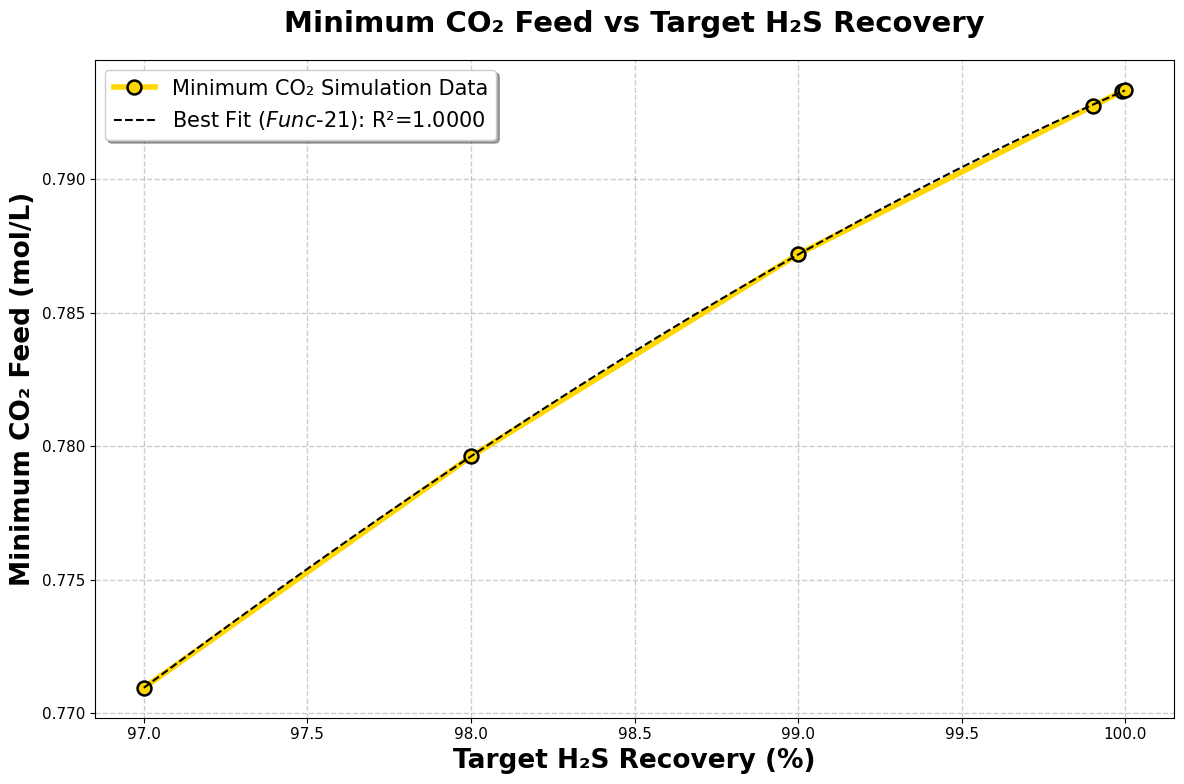


Best Parametric Fit: 3rd Degree Polynomial
R² = 0.999991
Best Parametric Form: Minimum CO₂ = a*Tar³ + b*Tar² + c*Tar + d
Parameters:
   a = -4.770922e-05
   b = 1.346937e-02
   c = -1.257242e+00
   d = 3.953305e+01


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Extract data from results
target_data = df_results['Target_Recovery'].values
min_co2_data = minCO2

# Define multiple fitting functions
def polynomial_1st(x, a, b): return a * x + b
def polynomial_2nd(x, a, b, c): return a * x**2 + b * x + c
def polynomial_3rd(x, a, b, c, d): return a * x**3 + b * x**2 + c * x + d
def polynomial_4th(x, a, b, c, d, e): return a * x**4 + b * x**3 + c * x**2 + d * x + e
def exponential_fit(x, a, b, c): return a * np.exp(b * x) + c
def exponential_decay(x, a, b, c, d): return a * np.exp(-b * x) + c * x + d
def exponential_power(x, a, b, c, d): return a * np.exp(b * x**c) + d
def logarithmic_simple(x, a, b): return a * np.log(x) + b
def logarithmic_complex(x, a, b, c): return a * np.log(x) + b * x + c
def power_law(x, a, b, c): return a * x**b + c
def power_exponential(x, a, b, c, d): return a * x**b * np.exp(c * x) + d
def rational_simple(x, a, b, c): return (a * x + b) / (x + c)
def rational_complex(x, a, b, c, d, e): return (a * x**2 + b * x + c) / (x**2 + d * x + e)

# List of functions to try
fitting_functions = [
    (polynomial_1st, "1st Degree Polynomial", [1, 1]),
    (polynomial_2nd, "2nd Degree Polynomial", [1, 1, 1]),
    (polynomial_3rd, "3rd Degree Polynomial", [1, 1, 1, 1]),
    (polynomial_4th, "4th Degree Polynomial", [1, 1, 1, 1, 1]),
    (exponential_fit, "Exponential Function", [1, -0.01, 1]),
    (exponential_decay, "Exponential Decay With Offset", [1, 0.01, 0.1, 1]),
    (exponential_power, "Exponential With Power", [1, -0.01, 1, 1]),
    (logarithmic_simple, "Simple Logarithmic", [1, 1]),
    (logarithmic_complex, "Complex Logarithmic", [1, 1, 1]),
    (power_law, "Power Law With Offset", [1, -1, 1]),
    (power_exponential, "Power Law With Exponential", [1, 1, 0.01, 1]),
    (rational_simple, "Simple Rational Function", [1, 1, 1]),
    (rational_complex, "Complex Rational Function", [1, 1, 1, 1, 1])
]

# Fit models
best_fit = None
best_r2 = -np.inf
best_name = ""
best_params = None

for func, name, initial_guess in fitting_functions:
    try:
        popt, _ = curve_fit(func, target_data, min_co2_data, p0=initial_guess, maxfev=10000)
        y_pred = func(target_data, *popt)

        # R² calculation
        ss_res = np.sum((min_co2_data - y_pred) ** 2)
        ss_tot = np.sum((min_co2_data - np.mean(min_co2_data)) ** 2)
        r2 = 1 - (ss_res / ss_tot)

        print(f"{name}: R² = {r2:.6f}")

        if r2 > best_r2:
            best_r2 = r2
            best_fit = func
            best_name = name
            best_params = popt

    except Exception as e:
        print(f"Failed to fit {name}: {e}")

# Plot results
target_fine = np.linspace(target_data.min(), target_data.max(), 1000)

plt.figure(figsize=(12, 8))
plt.plot(target_data, min_co2_data, 'o-', linewidth=4, markersize=10,
         color='gold', markerfacecolor='gold', markeredgecolor='black',
         markeredgewidth=1.8, label='Minimum CO₂ Simulation Data')

if best_fit is not None:
    y_fit = best_fit(target_fine, *best_params)
    plt.plot(target_fine, y_fit, '--', linewidth=1.5, color='black',
             label = rf"Best Fit ($\it{{Func\text{{-}}21}}$): R²={best_r2:.4f}")

plt.xlabel('Target H₂S Recovery (%)', fontsize=19, fontweight='bold')
plt.ylabel('Minimum CO₂ Feed (mol/L)', fontsize=19, fontweight='bold')
plt.title('Minimum CO₂ Feed vs Target H₂S Recovery', fontsize=21, fontweight='bold', pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=15)
plt.grid(True, alpha=0.4, linestyle='--', linewidth=1, color='grey')
plt.tight_layout()
plt.show()

# Best fitting summary
if best_fit is not None:
    print(f"\nBest Parametric Fit: {best_name}")
    print(f"R² = {best_r2:.6f}")

    # Map function names to their equations
    function_forms = {
        "1st Degree Polynomial": "Minimum CO₂ = a*Tar + b",
        "2nd Degree Polynomial": "Minimum CO₂ = a*Tar² + b*Tar + c",
        "3rd Degree Polynomial": "Minimum CO₂ = a*Tar³ + b*Tar² + c*Tar + d",
        "4th Degree Polynomial": "Minimum CO₂ = a*Tar⁴ + b*Tar³ + c*Tar² + d*Tar + e",
        "Exponential Function": "Minimum CO₂ = a*exp(b*Tar) + c",
        "Exponential Decay With Offset": "Minimum CO₂ = a*exp(-b*Tar) + c*Tar + d",
        "Exponential With Power": "Minimum CO₂ = a*exp(b*Tar^c) + d",
        "Simple Logarithmic": "Minimum CO₂ = a*ln(Tar) + b",
        "Complex Logarithmic": "Minimum CO₂ = a*ln(Tar) + b*Tar + c",
        "Power Law With Offset": "Minimum CO₂ = a*Tar^b + c",
        "Power Law With Exponential": "Minimum CO₂ = a*Tar^b * exp(c*Tar) + d",
        "Simple Rational Function": "Minimum CO₂ = (a*Tar + b) / (Tar + c)",
        "Complex Rational Function": "Minimum CO₂ = (a*Tar² + b*Tar + c) / (Tar² + d*Tar + e)"
    }

    # Print functional form
    if best_name in function_forms:
        print(f"Best Parametric Form: {function_forms[best_name]}")
    else:
        print("Best Parametric Form: [Not defined in dictionary]")

    # Print parameters
    param_names = ["a", "b", "c", "d", "e"]
    print("Parameters:")
    for i, p in enumerate(best_params):
        print(f"   {param_names[i]} = {p:.6e}")

# Actual vs Theoretical H₂S Partial Pressure

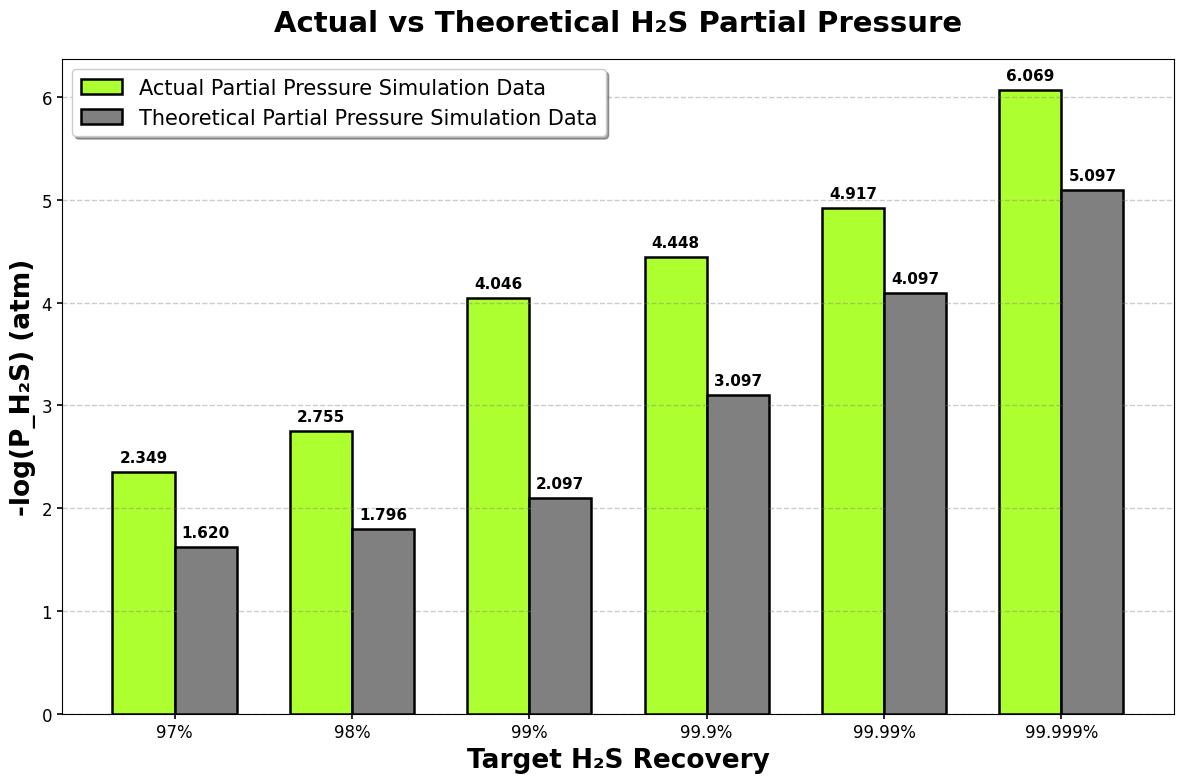

In [49]:
labels = ['97%', '98%', '99%', '99.9%', '99.99%', '99.999%']
data1 = -np.log10(df_results['Bottom_H2S_Fraction'][-6:]*P_operating)  # actual
# Convert target_sulphur_remaining_list to numpy array and get last 6 values
target_sulphur_remaining_array = np.array(target_sulphur_remaining_list)
data2 = -np.log10(target_sulphur_remaining_array[-6:])  # theoretical

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, np.round(data1, 3), width, label='Actual Partial Pressure Simulation Data', 
               color='greenyellow', edgecolor='black', linewidth=1.8)
bars2 = ax.bar(x + width/2, np.round(data2, 3), width, label='Theoretical Partial Pressure Simulation Data', 
               color='grey', edgecolor='black', linewidth=1.8)

# Labels and titles
ax.set_xlabel('Target H₂S Recovery', fontsize=19, fontweight='bold')
ax.set_ylabel('-log(P_H₂S) (atm)', fontsize=19, fontweight='bold')
ax.set_title('Actual vs Theoretical H₂S Partial Pressure', fontsize=21, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(loc='best', fontsize=15, frameon=True, fancybox=True, shadow=True)
ax.tick_params(axis='both', which='major', labelsize=12, width=1.2)
ax.grid(True, alpha=0.4, linestyle='--', axis='y', linewidth=1, color='grey')

# Bar value annotations
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()